# Exposures and Dark Frames

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time

%matplotlib inline

In [2]:
from bluesky_tutorial_utils import setup_data_saving
from bluesky import RunEngine
from bluesky.plans import count
from utils import simple_integration

RE = RunEngine()
catalog = setup_data_saving(RE)

In [3]:
from simulated_hardware import detector, load_sample, unload_sample, light, history_reset, sim_sleep
from simulated_hardware import _history

In [4]:
#we can eventually hide some of these in another file

def dark_light_subtract(sample_num, num_lights = 1):
    #close shutter if not already closed
    yield from light(False)
        
    #move to desired sample
    yield from load_sample(sample_num)
    
    #take dark image
    yield from count([detector])
    
    #open shutter
    yield from light(True)
    
    #take light image
    for i in range(num_lights):
        yield from count([detector])
    
    #close shutter to be nice to detector
    yield from light(False)
    

def process_data(pair, num_lights = 1, return_light = False, return_dark = False):
    #assuming pair is tuple
    my_dark = catalog[pair[0]].primary.read().detector_image[0]
    
    if return_dark:
        return simple_integration(my_dark, num_bins=301)
    
    dark_subbed_list = []
    
    for i in range(1,num_lights+1):
        this_light = catalog[pair[i]].primary.read().detector_image[0]
        
        if return_light:
            dark_subbed_list.append(this_light)
        else:
            dark_subbed_list.append(this_light - my_dark)
    
    if num_lights == 1:
        return simple_integration(dark_subbed_list[0],num_bins=301)
    
    else: # more than one
        int_list = []
        for j in range(len(dark_subbed_list)):
            int_list.append(simple_integration(dark_subbed_list[j],num_bins=301))
    
        return np.array(int_list).T

def make_ideal_data(sample_num):
    _history['perfect_data'] = True

    perfect_pair = RE(dark_light_subtract(sample_num))    

    this_light = catalog[perfect_pair[1]].primary.read().detector_image[0]

    perfect_int = simple_integration(this_light,num_bins=301)

    _history['perfect_data'] = False
    
    return perfect_int

def normalized_residual(data, ideal):
    return sum(abs(data-ideal))/len(data)

def normalized_residual_sqrd(data, ideal):
    return sum(np.array(data-ideal)**2.0)/len(data)


def retrieve_im(num):
    return catalog[num].primary.read().detector_image[0]

In [5]:
_history['action_time'] = .5

perfect_int1 = make_ideal_data(1)
perfect_int2 = make_ideal_data(2)
perfect_int3 = make_ideal_data(3)
perfect_int4 = make_ideal_data(4)

something empty


## Simulation intro text

In [6]:
#load sample
RE(load_sample(1))

#turn on light
RE(light(True))

#count
RE(count([detector]))


('ac21a060-c198-4060-82f9-b0fed35736ce',)

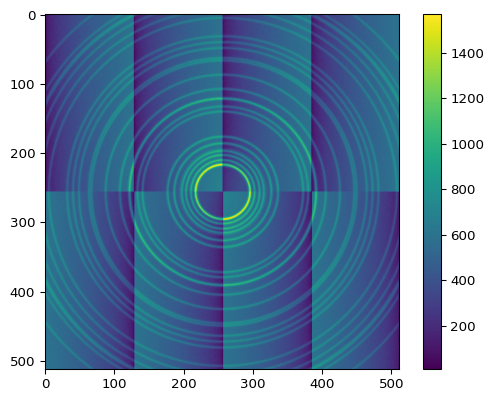

In [7]:
#retrieve image from databroker
my_im = catalog[-1].primary.read().detector_image[0]
#plot
plt.figure()
plt.imshow(my_im)
plt.colorbar()

### Dark image introduction

In [8]:
#we started at t=0, so we'll just go before then to measure the dark.
#time_travel(-1)

RE(light(False))

sim_sleep(10)

RE(count([detector]))

my_dark = catalog[-1].primary.read().detector_image[0]

sleeping for 10


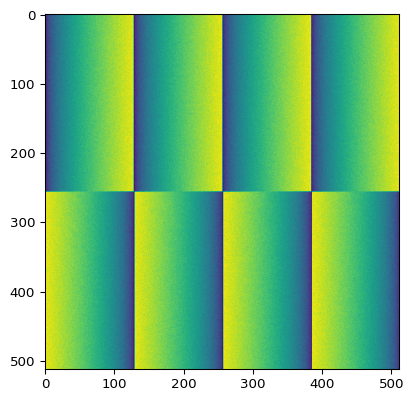

In [9]:
plt.figure()
plt.imshow(my_dark)

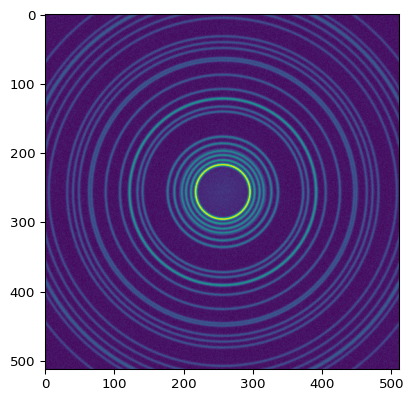

In [10]:
plt.figure()
plt.imshow(my_im - my_dark)

### Integrate to get pattern

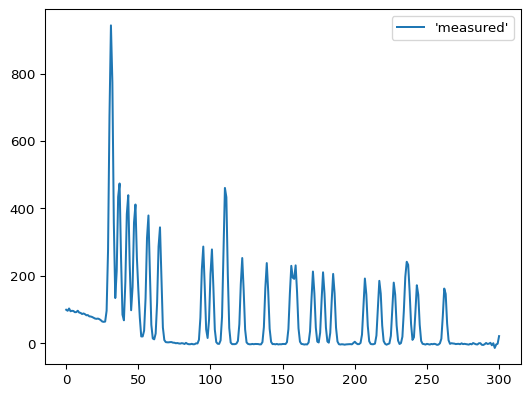

In [11]:
intensity = simple_integration(my_im - my_dark,num_bins=301)

plt.figure()
plt.plot(intensity, label="'measured'")
plt.legend()

### Bluesky plan to gather light/dark automatically

#### Demonstrate how to make a simple plan using bluesky (unless we have one already defined at this point).

In [12]:
def dark_light_subtract(sample_num, num_lights = 1):
    uids = []
    #close shutter if not already closed
    yield from light(False)
        
    #move to desired sample
    yield from load_sample(sample_num)
    
    #take dark image
    uid = yield from count([detector])
    uids.append(uid)
    
    #open shutter
    yield from light(True)
    
    #take light image
    for i in range(num_lights):
        uid = yield from count([detector])
        uids.append(uid)
    
    #close shutter to be nice to detector
    yield from light(False)
    return uids

Run engine returns uids

In [13]:
uids = RE(dark_light_subtract(1))

In [14]:
uids

('82a29808-7011-4a36-903a-ce3afdf2a0a5',
 'd1c1f884-8abc-47f1-a005-9b229294f1d9')

#### At beamline, we have autoreduction.  Here, we wrote a helper function called "process_data" which will return your integrated intensity.

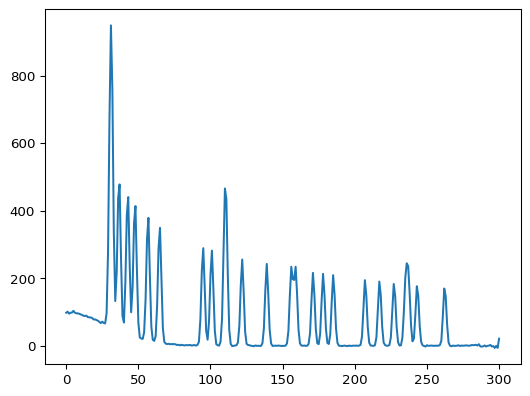

In [15]:
this_intensity = process_data(uids)

plt.figure()
plt.plot(this_intensity)

### Part B: Managing multiple samples.

#### How to Turn-on / Turn-off light, and how to switch between samples.


In [16]:
#history_reset()

RE(light(True))

RE(load_sample(1))

RE(load_sample(2))

RE(load_sample(3))



()

#### Explain that much like many real detectors, our simulated detector has some degree of memory.  Burn-in effects are possible, as are after-image.

In [17]:
uids = RE(dark_light_subtract(1))

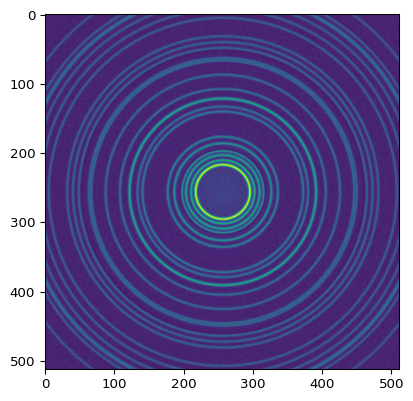

In [18]:
my_light = retrieve_im(uids[1])
my_dark = retrieve_im(uids[0])

plt.figure()
plt.imshow(my_light - my_dark)

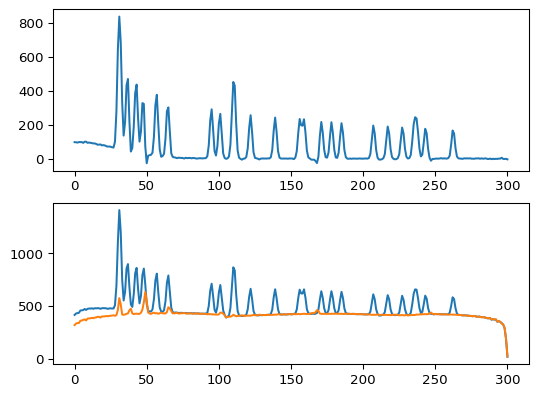

In [19]:
plt.figure()
plt.subplot(211)
plt.plot(process_data(uids))
plt.subplot(212)
plt.plot(process_data(uids,return_light=True))
plt.plot(process_data(uids,return_dark=True))


#### We see features in the dark (peaks), that tell us our dark is kind of no-good.

In [20]:
sim_sleep(100)

uids = RE(dark_light_subtract(1))



sleeping for 100


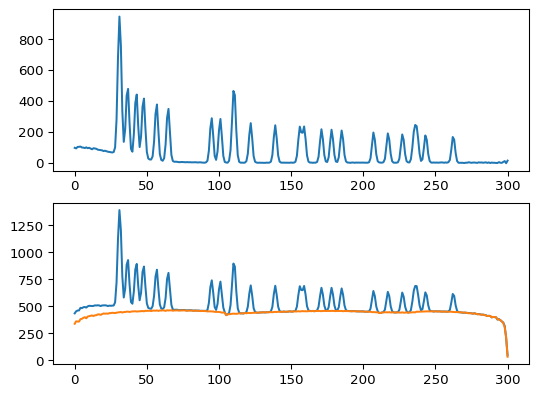

In [21]:
plt.figure()
plt.subplot(211)
plt.plot(process_data(uids))
plt.subplot(212)
plt.plot(process_data(uids,return_light=True))
plt.plot(process_data(uids,return_dark=True))


##### Much cleaner looking dark, no outstanding peaks. Clearly, managment of darks is an important aspect of diffraction measurements (at least on these detectors).

### Part C : More samples, more problems.

#### In a real experement, you often switch between samples, and they don't all scatter the same.  We often measure multiple times on a single sample and sum the results to improve statistics.

In [22]:
#change to noisy detector

_history['noise'] = 1000
_history['action_time'] = 20.0 # 1.0
_history['panel_wl'] = 3000 # 8000

Look at single scan vs. perfect data

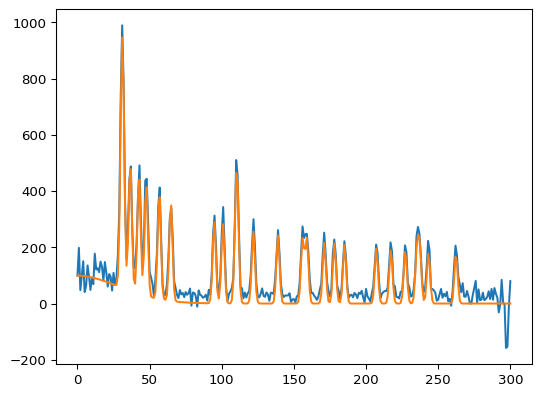

In [23]:
uid = RE(dark_light_subtract(1))
plt.figure()
plt.plot(process_data(uid))
plt.plot(perfect_int1)


Run multiple scans on single sample (single dark)

In [24]:
uids1 = RE(dark_light_subtract(1, num_lights=10))

In [25]:
reduced_data1 = process_data(uids1, num_lights=len(uids1)-1)


Plot vs. Perfect data.

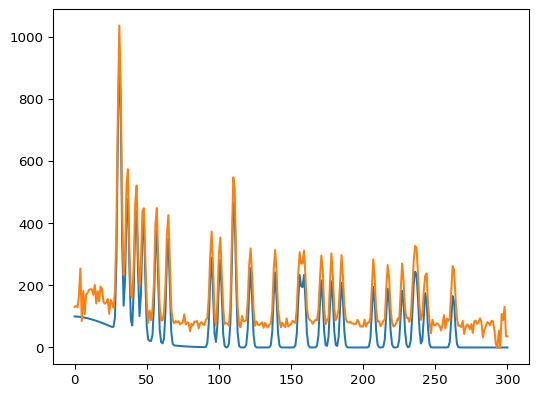

In [26]:
plt.figure()
plt.plot(perfect_int1)
plt.plot(reduced_data1.mean(axis=1));


### Why does our average look so bad?  Huge background.  Let's look at individual runs.

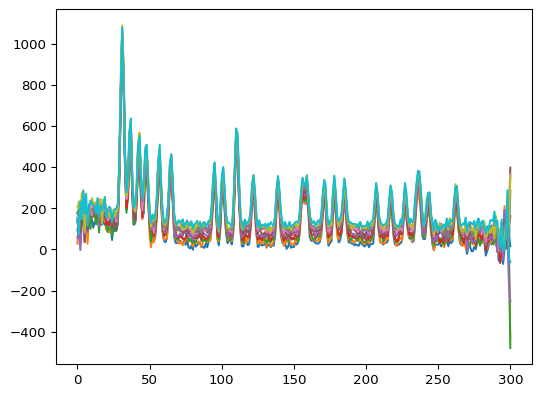

In [27]:
plt.figure()
plt.plot(reduced_data1);


#### We see there is a slowly rising background, which is why our average was corrupted.  What is happening?

#### Just like a real detector, our simulated detector has a slowly varying background.  We need to refresh our dark more frequently to account for this.

Here is a crude plan (RE in a loop) which has a sleep in between our shots, each of which has it's own dark.

In [28]:
history_reset()
new_int_list = []
def custom_plan():
    for i in range(10):
        this_pair = yield from dark_light_subtract(1)
        new_int_list.append(process_data(this_pair))
        sim_sleep(60)
        
RE(custom_plan())

new_int_list = np.array(new_int_list).T

something empty


sleeping for 60


sleeping for 60


sleeping for 60


sleeping for 60


sleeping for 60


sleeping for 60


sleeping for 60


sleeping for 60


sleeping for 60


sleeping for 60


Now compare this to the ideal data

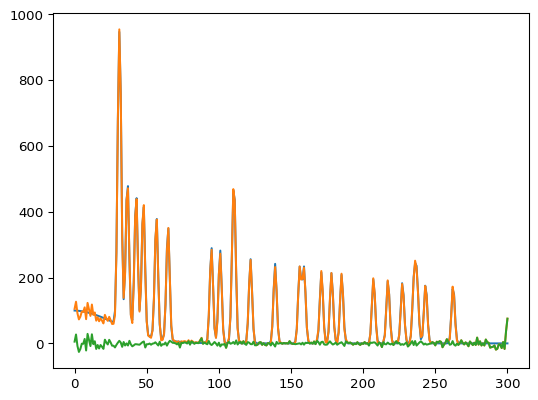

In [29]:
plt.figure()
plt.plot(perfect_int1)
plt.plot(new_int_list.mean(axis=1))
plt.plot(new_int_list.mean(axis=1) - perfect_int1)

## Concluding remarks!